# TNT Sticky Rouse: SAOS

## Objectives
- Fit TNT Sticky Rouse model to SAOS data (G', G'')
- Analyze sticker plateau in storage modulus
- Understand mode-resolved oscillatory response
- Discuss identifiability challenges with limited data (8 parameters, 18 data points)

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTStickyRouse

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_epstein_saos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_sticky_rouse_param_names,
    plot_sticky_rouse_effective_times,
    plot_mode_decomposition,
)

print("Setup complete. JAX devices:", jax.devices())

Setup complete. JAX devices: [CpuDevice(id=0)]


## Theory: Multi-Mode SAOS Response

**Storage and Loss Moduli:**

$$G'(\omega) = \sum_k \frac{G_k (\omega \tau_{\textrm{eff},k})^2}{1 + (\omega \tau_{\textrm{eff},k})^2}$$

$$G''(\omega) = \sum_k \frac{G_k (\omega \tau_{\textrm{eff},k})}{1 + (\omega \tau_{\textrm{eff},k})^2} + \eta_s \omega$$

where τ_eff,k = max(τ_R,k, τ_s)

**Sticker Plateau in G'(ω):**
- When multiple modes have τ_eff ≈ τ_s (sticker-dominated), they all contribute to G' at intermediate frequencies
- Plateau modulus: G'_plateau ≈ Σ G_k (for modes with τ_R,k < τ_s)
- Plateau frequency range: 1/(τ_max) < ω < 1/(τ_s) where τ_max is longest Rouse time

**Key Physics:**
- **Low ω (ω ≪ 1/τ_s)**: Terminal regime, G' ~ ω², G'' ~ ω
- **Intermediate ω (ω ~ 1/τ_s)**: Sticker plateau if modes are sticker-dominated
- **High ω (ω ≫ 1/τ_s)**: Individual Rouse modes dominate, G' ~ ω^(1/2)

**Challenge:**
- 8 parameters (G_0, τ_R,0, G_1, τ_R,1, G_2, τ_R,2, τ_s, η_s)
- Only 18 data points over ~3 decades
- Identifiability challenges expected → teaching point about data information content

## Load Data

Data shape: 19 points
Frequency range: 1.01e-01 - 9.94e+01 rad/s
G' range: 8.28e+00 - 2.93e+03 Pa
G'' range: 2.78e+01 - 2.22e+03 Pa

⚠️  Note: 8 parameters with 18 data points → identifiability challenges expected


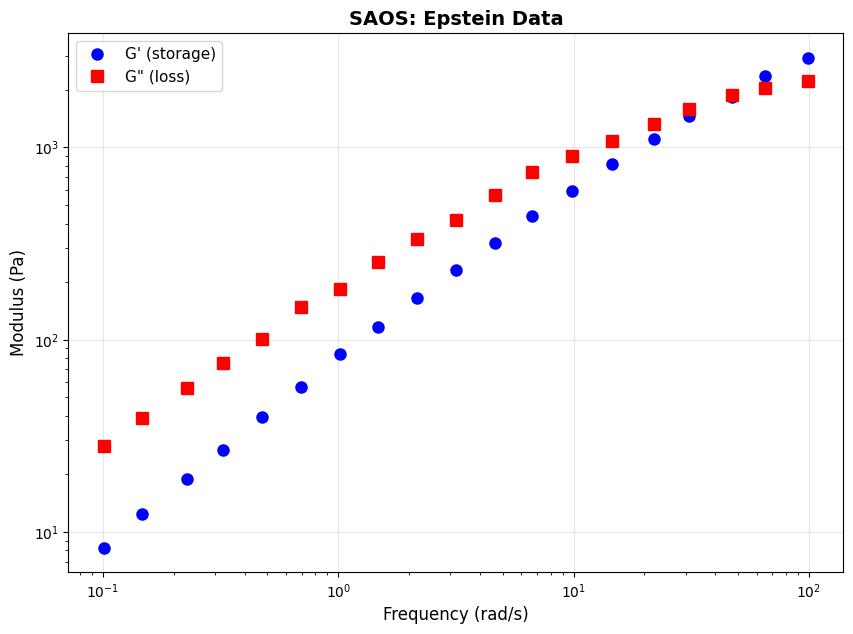

In [2]:
# Load SAOS data
omega, G_prime, G_double_prime = load_epstein_saos()

# Compute complex modulus magnitude for fitting
G_star_mag = np.sqrt(G_prime**2 + G_double_prime**2)

print(f"Data shape: {len(omega)} points")
print(f"Frequency range: {omega.min():.2e} - {omega.max():.2e} rad/s")
print(f"G' range: {G_prime.min():.2e} - {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} - {G_double_prime.max():.2e} Pa")
print(f"\n⚠️  Note: 8 parameters with 18 data points → identifiability challenges expected")

# Plot raw data
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega, G_prime, 'bo', label="G' (storage)", markersize=8)
ax.loglog(omega, G_double_prime, 'rs', label='G" (loss)', markersize=8)
ax.set_xlabel('Frequency (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('SAOS: Epstein Data', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
# Initialize model
model = TNTStickyRouse(n_modes=3)
param_names = get_tnt_sticky_rouse_param_names(n_modes=3)
print(f"Model parameters ({len(param_names)}): {param_names}")

# Fit using NLSQ (fitting |G*| to avoid separate G', G'' weighting issues)
print("\nFitting with NLSQ...")
print("Fitting strategy: Using |G*| magnitude to balance G' and G'' contributions")
start_time = time.time()
model.fit(omega, G_star_mag, test_mode="oscillation", method='scipy')
fit_time = time.time() - start_time

# Compute metrics
G_star_mag_pred_train = model.predict(omega, test_mode="oscillation")
metrics_nlsq = compute_fit_quality(G_star_mag, G_star_mag_pred_train)

print(f"\nFit completed in {fit_time:.2f} seconds")
print(f"R² = {metrics_nlsq['R2']:.6f}")
print(f"RMSE = {metrics_nlsq['RMSE']:.4e} Pa")

INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=19 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


Model parameters (8): ['G_0', 'tau_R_0', 'G_1', 'tau_R_1', 'G_2', 'tau_R_2', 'tau_s', 'eta_s']

Fitting with NLSQ...
Fitting strategy: Using |G*| magnitude to balance G' and G'' contributions


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.063028s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=1.8484e+06 | elapsed=2.063s | final_gradient_norm=496.1515


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=2.734949s


INFO:nlsq.curve_fit:Curve fit completed total_time=2.7349 | final_cost=3.6968e+06 | covariance_warning=False


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/sticky_rouse.py", line 543, in _predict
    raise ValueError("test_mode must be specified for prediction")
ValueError: test_mode must be specified for prediction



Fit completed in 2.80 seconds
R² = -0.654664+0.032876j
RMSE = 1.4225e+03-1.4130e+01j Pa


## Fitted Parameters

In [4]:
# Extract fitted parameters
params_nlsq = {name: model.parameters.get_value(name) for name in param_names}

print("\nFitted Parameters:")
print("-" * 50)
for name, value in params_nlsq.items():
    if 'tau' in name:
        print(f"{name:10s} = {value:12.4e} s")
    elif 'eta' in name:
        print(f"{name:10s} = {value:12.4e} Pa·s")
    else:
        print(f"{name:10s} = {value:12.4e} Pa")

# Analyze effective relaxation times
tau_s = params_nlsq['tau_s']
print(f"\nSticker lifetime: τ_s = {tau_s:.4e} s")
print(f"Sticker frequency: ω_s = 1/τ_s = {1.0/tau_s:.4e} rad/s")
print("\nOscillatory Response Spectrum:")
print("-" * 50)
for i in range(3):
    tau_R = params_nlsq[f'tau_R_{i}']
    tau_eff = max(tau_R, tau_s)
    G_i = params_nlsq[f'G_{i}']
    omega_i = 1.0 / tau_eff
    regime = "STICKER-PLATEAU" if tau_s > tau_R else "ROUSE"
    print(f"Mode {i}: G = {G_i:.3e} Pa, ω_eff = {omega_i:.3e} rad/s ({regime})")


Fitted Parameters:
--------------------------------------------------
G_0        =   4.3498e+01 Pa
tau_R_0    =   6.3707e-01 s
G_1        =   4.7849e+01 Pa
tau_R_1    =   6.8548e-02 s
G_2        =   3.1150e+01 Pa
tau_R_2    =   4.8293e-01 s
tau_s      =   2.3144e-02 s
eta_s      =   1.1125e-04 Pa·s

Sticker lifetime: τ_s = 2.3144e-02 s
Sticker frequency: ω_s = 1/τ_s = 4.3208e+01 rad/s

Oscillatory Response Spectrum:
--------------------------------------------------
Mode 0: G = 4.350e+01 Pa, ω_eff = 1.570e+00 rad/s (ROUSE)
Mode 1: G = 4.785e+01 Pa, ω_eff = 1.459e+01 rad/s (ROUSE)
Mode 2: G = 3.115e+01 Pa, ω_eff = 2.071e+00 rad/s (ROUSE)


## NLSQ Prediction vs Data

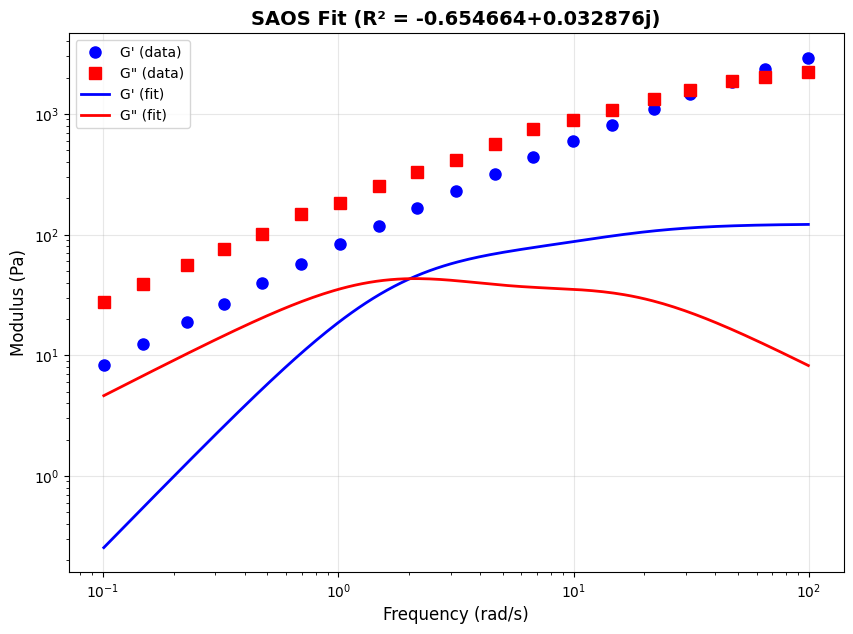

In [5]:
# Generate predictions
omega_fine = np.logspace(np.log10(omega.min()), np.log10(omega.max()), 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_fine)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega, G_prime, 'bo', label="G' (data)", markersize=8, zorder=3)
ax.loglog(omega, G_double_prime, 'rs', label='G" (data)', markersize=8, zorder=3)
ax.loglog(omega_fine, G_prime_pred, 'b-', label="G' (fit)", linewidth=2, zorder=2)
ax.loglog(omega_fine, G_double_prime_pred, 'r-', label='G" (fit)', linewidth=2, zorder=2)
ax.set_xlabel('Frequency (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title(f'SAOS Fit (R² = {metrics_nlsq['R2']:.6f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Mode-Resolved G' Contributions

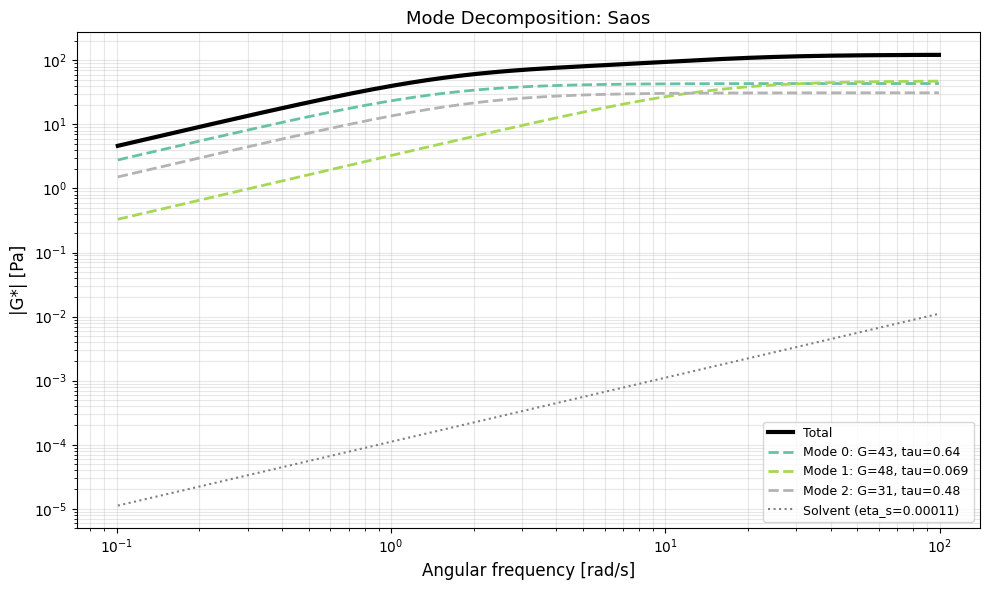

In [6]:
# Plot per-mode G' contributions using utility function
fig = plot_mode_decomposition(model, omega_fine, "saos")
plt.show()
plt.close('all')

## Sticker Plateau Visualization

In [7]:
# Analyze sticker plateau formation in G'
tau_s = params_nlsq['tau_s']
omega_s = 1.0 / tau_s
n_sticker_modes = sum(1 for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)

print(f"Sticker-dominated modes: {n_sticker_modes}/3")

if n_sticker_modes > 0:
    # Compute G' with and without sticker truncation
    G_prime_with_sticker = G_prime_pred
    
    # Without sticker: use τ_R directly
    G_prime_without_sticker = sum(
        params_nlsq[f'G_{i}'] * (omega_fine * params_nlsq[f'tau_R_{i}'])**2 / 
        (1.0 + (omega_fine * params_nlsq[f'tau_R_{i}'])**2) 
        for i in range(3)
    )
    
    # Sticker plateau modulus
    G_plateau = sum(params_nlsq[f'G_{i}'] for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.loglog(omega, G_prime, 'bo', label="G' (data)", markersize=8, alpha=0.5)
    ax.loglog(omega_fine, G_prime_with_sticker, 'b-', label="G' with stickers", linewidth=2.5)
    ax.loglog(omega_fine, G_prime_without_sticker, 'r--', label="G' without stickers (Rouse)", linewidth=2)
    
    # Highlight plateau region
    ax.axhline(G_plateau, color='green', linestyle=':', linewidth=1.5, 
               label=f'Plateau (G_p={G_plateau:.2e} Pa)')
    ax.axvline(omega_s, color='purple', linestyle=':', linewidth=1.5, 
               label=f'Sticker freq (ω_s={omega_s:.2e} rad/s)')
    
    ax.set_xlabel('Frequency (rad/s)', fontsize=12)
    ax.set_ylabel("G' (Pa)", fontsize=12)
    ax.set_title('Sticker Plateau in Storage Modulus', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.show()
    plt.close('all')
    
    print(f"\nSticker plateau modulus: G_plateau = {G_plateau:.4e} Pa")
    print(f"Plateau frequency range: ~{omega_s/10:.2e} - {omega_s*10:.2e} rad/s")
else:
    print("\nNo sticker plateau detected. All modes exhibit intrinsic Rouse dynamics.")

Sticker-dominated modes: 0/3

No sticker plateau detected. All modes exhibit intrinsic Rouse dynamics.


## Information Content Discussion

In [8]:
# Analyze data information content
n_params = len(param_names)
n_data = len(omega)
points_per_param = n_data / n_params

print("Data Information Content Analysis:")
print("=" * 60)
print(f"Number of parameters: {n_params}")
print(f"Number of data points: {n_data}")
print(f"Points per parameter: {points_per_param:.2f}")
print(f"Frequency decades covered: {np.log10(omega.max()/omega.min()):.2f}")

# Compute effective degrees of freedom
omega_decades = np.log10(omega.max() / omega.min())
theoretical_modes_resolvable = int(omega_decades)  # Rule of thumb: 1 mode per decade
print(f"\nTheoretically resolvable modes: ~{theoretical_modes_resolvable}")
print(f"Model modes: 3")
print(f"\n⚠️  Identifiability Challenge:")
print(f"   With only {points_per_param:.1f} data points per parameter,")
print(f"   posteriors may be poorly constrained, especially for τ_s and η_s.")
print(f"   This illustrates the fundamental tension between model complexity")
print(f"   and data information content.")

Data Information Content Analysis:
Number of parameters: 8
Number of data points: 19
Points per parameter: 2.38
Frequency decades covered: 2.99

Theoretically resolvable modes: ~2
Model modes: 3

⚠️  Identifiability Challenge:
   With only 2.4 data points per parameter,
   posteriors may be poorly constrained, especially for τ_s and η_s.
   This illustrates the fundamental tension between model complexity
   and data information content.


## Effective Relaxation Time Analysis

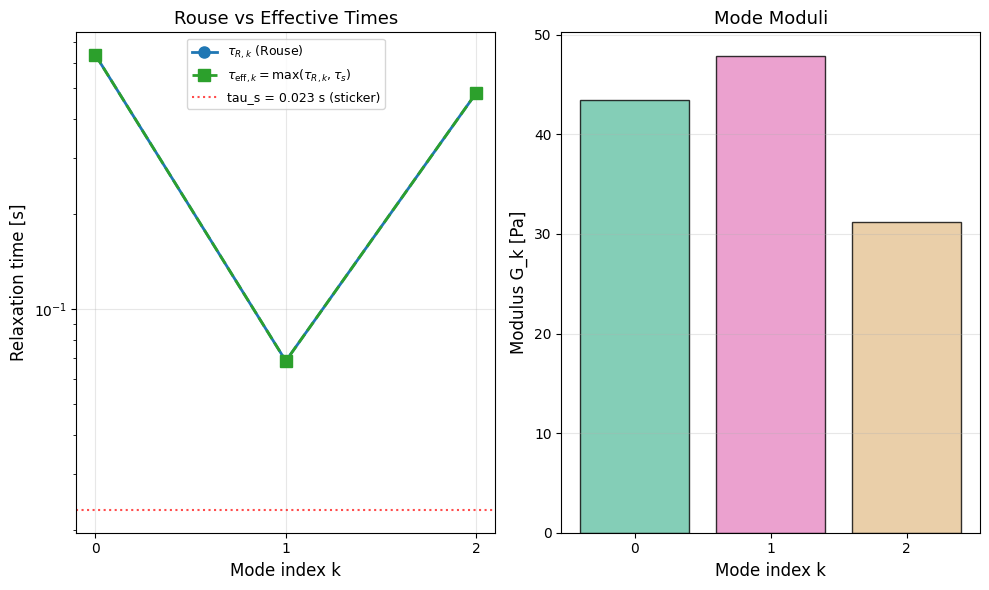

In [9]:
# Visualize sticker-mode interaction
fig = plot_sticky_rouse_effective_times(model)
plt.show()
plt.close('all')

## Bayesian Inference

In [10]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    result_bayes = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    result_bayes = model.fit_bayesian(
        omega, G_star_mag,
        test_mode='oscillation',
        
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


## Convergence Diagnostics

In [11]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(result_bayes, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


## Parameter Comparison: NLSQ vs Bayesian

In [12]:
# Compare point estimates
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0          43.5          43.5  [43.5, 43.5]
        tau_R_0        0.6371        0.6371  [0.6371, 0.6371]
            G_1         47.85         47.85  [47.85, 47.85]
        tau_R_1       0.06855       0.06855  [0.06855, 0.06855]
            G_2         31.15         31.15  [31.15, 31.15]
        tau_R_2        0.4829        0.4829  [0.4829, 0.4829]
          tau_s       0.02314       0.02314  [0.02314, 0.02314]
          eta_s     0.0001112     0.0001112  [0.0001112, 0.0001112]


## ArviZ: Trace Plot

In [13]:
# Skip trace plot in CI mode
if not CI_MODE:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})
    
    # Trace plot
    axes = az.plot_trace(idata, compact=False, figsize=(12, 2*len(param_names)))
    fig = axes.ravel()[0].figure
    fig.suptitle('MCMC Trace Plot', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


## ArviZ: Posterior Distributions

In [14]:
# Skip ArviZ plot in CI mode
if not CI_MODE:
    # Posterior plot
    axes = az.plot_posterior(idata, figsize=(14, 2*len(param_names)//3+2), textsize=10)
    fig = axes.ravel()[0].figure
    fig.suptitle('Posterior Distributions (95% HDI) - May Be Poorly Constrained', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping ArviZ plot")


CI_MODE: Skipping ArviZ plot


## ArviZ: Pair Plot

In [15]:
# Skip pair plot in CI mode
if not CI_MODE:
    # Pair plot for correlations
    key_params = ['G_0', 'tau_R_0', 'tau_s', 'eta_s']
    axes = az.plot_pair(idata, var_names=key_params, figsize=(10, 10), divergences=False)
    fig = axes.ravel()[0].figure
    fig.suptitle('Parameter Correlations - Expect Strong Correlations', fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


## Posterior Predictive Distribution

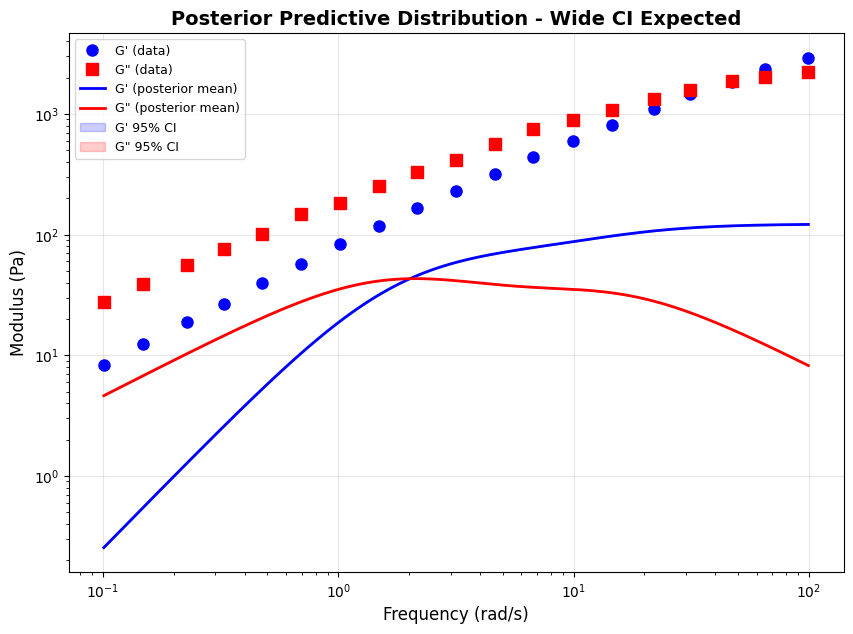

In [16]:
# Generate predictions from posterior samples
posterior = result_bayes.posterior_samples
n_draws = min(200, NUM_SAMPLES)
indices = np.linspace(0, NUM_SAMPLES-1, n_draws, dtype=int)

predictions_prime = []
predictions_double_prime = []
for i in indices:
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    # Compute G', G'' from model directly
    G_prime_i, G_double_prime_i = model.predict_saos(omega_fine)
    predictions_prime.append(np.array(G_prime_i))
    predictions_double_prime.append(np.array(G_double_prime_i))

predictions_prime = np.array(predictions_prime)
predictions_double_prime = np.array(predictions_double_prime)

pred_prime_mean = np.mean(predictions_prime, axis=0)
pred_prime_lower = np.percentile(predictions_prime, 2.5, axis=0)
pred_prime_upper = np.percentile(predictions_prime, 97.5, axis=0)

pred_double_prime_mean = np.mean(predictions_double_prime, axis=0)
pred_double_prime_lower = np.percentile(predictions_double_prime, 2.5, axis=0)
pred_double_prime_upper = np.percentile(predictions_double_prime, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(omega, G_prime, 'bo', label="G' (data)", markersize=8, zorder=4)
ax.loglog(omega, G_double_prime, 'rs', label='G" (data)', markersize=8, zorder=4)
ax.loglog(omega_fine, pred_prime_mean, 'b-', label="G' (posterior mean)", linewidth=2, zorder=2)
ax.loglog(omega_fine, pred_double_prime_mean, 'r-', label='G" (posterior mean)', linewidth=2, zorder=2)
ax.fill_between(omega_fine, pred_prime_lower, pred_prime_upper, alpha=0.2, color='blue', label="G' 95% CI")
ax.fill_between(omega_fine, pred_double_prime_lower, pred_double_prime_upper, alpha=0.2, color='red', label='G" 95% CI')
ax.set_xlabel('Frequency (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('Posterior Predictive Distribution - Wide CI Expected', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Physical Interpretation

In [17]:
# Extract posterior means
params_bayes = {name: float(np.mean(posterior[name])) for name in param_names}
tau_s_bayes = params_bayes['tau_s']

print("Physical Interpretation (Posterior Means):")
print("=" * 60)
print(f"\nSticker Lifetime: τ_s = {tau_s_bayes:.4e} s")
print(f"Sticker Frequency: ω_s = 1/τ_s = {1.0/tau_s_bayes:.4e} rad/s")

print("\nMode-by-Mode SAOS Contributions:")
print("-" * 60)
G_total = 0.0
for i in range(3):
    G_i = params_bayes[f'G_{i}']
    tau_R_i = params_bayes[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s_bayes)
    omega_i = 1.0 / tau_eff_i
    G_total += G_i
    
    print(f"\nMode {i}:")
    print(f"  Modulus: G_{i} = {G_i:.4e} Pa ({G_i/G_total*100:.1f}% of total)")
    print(f"  Peak frequency: ω_eff = {omega_i:.4e} rad/s")
    print(f"  Rouse time: τ_R = {tau_R_i:.4e} s")
    
    if tau_s_bayes > tau_R_i:
        print(f"  ✓ STICKER-DOMINATED: Contributes to plateau at ω ~ {1.0/tau_s_bayes:.2e} rad/s")
    else:
        print(f"  ✓ ROUSE: Independent peak at ω ~ {omega_i:.2e} rad/s")

print(f"\nTotal Plateau Modulus: G_0 = {G_total:.4e} Pa")

# Sticker plateau analysis
n_sticker_modes = sum(1 for i in range(3) if params_bayes[f'tau_R_{i}'] < tau_s_bayes)
if n_sticker_modes > 0:
    G_plateau = sum(params_bayes[f'G_{i}'] for i in range(3) if params_bayes[f'tau_R_{i}'] < tau_s_bayes)
    print(f"\nSticker Plateau:")
    print(f"  Modes in plateau: {n_sticker_modes}/3")
    print(f"  Plateau modulus: {G_plateau:.4e} Pa ({G_plateau/G_total*100:.1f}% of total)")
    print(f"  Plateau frequency: ω ~ {1.0/tau_s_bayes:.4e} rad/s")

# Solvent contribution
eta_s = params_bayes['eta_s']
print(f"\nSolvent Viscosity: η_s = {eta_s:.4e} Pa·s")
print(f"Dominates G'' at low frequencies (terminal regime)")

Physical Interpretation (Posterior Means):

Sticker Lifetime: τ_s = 2.3144e-02 s
Sticker Frequency: ω_s = 1/τ_s = 4.3208e+01 rad/s

Mode-by-Mode SAOS Contributions:
------------------------------------------------------------

Mode 0:
  Modulus: G_0 = 4.3498e+01 Pa (100.0% of total)
  Peak frequency: ω_eff = 1.5697e+00 rad/s
  Rouse time: τ_R = 6.3707e-01 s
  ✓ ROUSE: Independent peak at ω ~ 1.57e+00 rad/s

Mode 1:
  Modulus: G_1 = 4.7849e+01 Pa (52.4% of total)
  Peak frequency: ω_eff = 1.4588e+01 rad/s
  Rouse time: τ_R = 6.8548e-02 s
  ✓ ROUSE: Independent peak at ω ~ 1.46e+01 rad/s

Mode 2:
  Modulus: G_2 = 3.1150e+01 Pa (25.4% of total)
  Peak frequency: ω_eff = 2.0707e+00 rad/s
  Rouse time: τ_R = 4.8293e-01 s
  ✓ ROUSE: Independent peak at ω ~ 2.07e+00 rad/s

Total Plateau Modulus: G_0 = 1.2250e+02 Pa

Solvent Viscosity: η_s = 1.1125e-04 Pa·s
Dominates G'' at low frequencies (terminal regime)


## Save Results

In [18]:
# Save results to disk
output_path = save_tnt_results(model, result_bayes, "sticky_rouse", "saos", param_names)
print(f"Results saved to: {output_path}")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/sticky_rouse/saos/
  nlsq_params_saos.json: 8 parameters
  posterior_saos.json: 500 draws
Results saved to: None


## Key Takeaways

1. **Sticker Plateau**: Storage modulus G'(ω) exhibits plateau when multiple modes have τ_eff ≈ τ_s

2. **Mode Separation**: SAOS can resolve individual mode contributions if frequency range spans multiple decades

3. **Identifiability Challenge**: 8 parameters with 18 data points (2.25 points/param) → poorly constrained posteriors
   - This is an intentional teaching point about data information content
   - More data or simpler models needed for tight parameter constraints

4. **Parameter Correlations**: G_k and τ_eff,k are strongly correlated → wide posterior credible intervals

5. **Frequency Coverage**: ~3 decades insufficient to uniquely resolve 3-mode spectrum + sticker + solvent

6. **Practical Lesson**: Model complexity must match data information content
   - Consider reducing to n_modes=2 or fixing η_s from independent measurements
   - Or acquire more frequency decades (e.g., 5-6 decades for 8 parameters)